# Deep Learning for text

## Natural language processing: Bird's eye view

In CS, we refer to human language as 'natural' languages, to distinguish them form languages designed for machines. Every machine language was designed: its starting point was a human engineer writing down a set of formal rules to describe what statements you could make in that language and what they meant.Rules came first, and people only started using the language once the rule set was complete. With human language, it's the reverse: usage comes first, rules arise later. Natural language was shaped by an evolution process, much like biological organisms - that's what makes it "natural". Its "rules", like the grammar of English, were formalized after the fact and are often ignored or broken by its users. As a result, while machine-readable language is highly structured and rigorous, using precise syntactic rules to weave together exactly defined concepts from a fixed vocabulary, natural language is messy-ambiguous, chaotic, sprawling, and constantly in flux.\
Modern NLP is about using machine learning and large datasets to give computers the ability not to understand language, which is a more lofty goal, but to ingest a piece of language as input and return something useful, like predicting the following:
* Text classification
* Content filtering
* Sentiment Analysis
* Language modeling
* Translation
* Summarization
* etc..

## Preparing text data
Deep learning models, being differentiable functions, can only process numeric tensors: they can't take raw text as input. Vectorizing text is the process of transforming text into numeric tensors. Text vectorization processes come in many shapes and forms, but they all follow the same template:
* First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
* You split the text into units (called tokens), such as characters, word, or groups of words. This is called tokenization.
* You convert each such token into a numerical vector. This will usually involve firts indexing all tokens present in the data.\
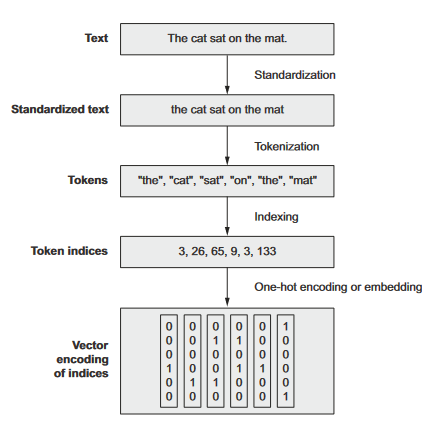

### Test standardization
Consider two senteces:
* "sunset came. i was staring at the Mexico sky. Isnt nature splendid??"
* "Sunset came; I stared at the México sky. Isn't nature splendid?"
They are very similar, almost identical. Yet, if you were to convert them to byte strings, they would end up with very different representations, because "i" and "I" are two different characters, and so on. A machine learning model does not know a priori that "i" and "I" are the same letter, and so on.
Text standardization is a basic form of feature engineering that aims to erase encoding differences that you don't want your model to have to deal with. It is not exclusive to machine learning either, you would have to do the same thing if you were building a search engine.\
One of the simplest and most widespread standardization schemes is "convert to lowercase and remove punctuation characters". Another comon transformation is converting special characters to a standard form.\
Lastly, a much more advanced standardization pattern that is more rarely used in a machine learning context is stemming. converting variations of a term into a single shared represetnation.\
With these standardization techniques, your model will require less training data and will generalize better. Of course, standardization may also erase some amount of information, so always keep the context in mind.

### Text splitting (Tokenization)

Once your text is standardized, you need to break it up into units to be vectorized, a step called tokenization. You could do this in three different ways:
* Word-level: tokens are space-separated (or punctuation separated) substrings. A variant of this is to further split words into subwords when applicable.
* N-gram: tokens are groups of N consecutive words.
* Character-level: each character is its own token. Rarely used.
In general, you always use word-level or N-gram tokenization. There are two kinds of text-processing models: those that care about word order, called sequence models, and those that treat input words as a set, discarding their original order, called bag-of-words models. If you are bulding a  sequence model, you will use word-level and if you are building a bag-of-words model, you will use N-gram. N-grams are a way to artificially inject a small amount of ocal word order information into the model.

### Vocabulary indexing
Once the text is split into tokens, you need to encode each token into a numerical representation. You could potentially do this in a stateless way, such as by hashing each token into a fixed binary vector, but in practice, the way you'd go about it is to build an index of all terms found in the training data, and assign a unique integer to each entry in vocabulary.

In [1]:
# vocabulary = {}

# for text in dataset:
#     text = standardize(text)
#     tokens = tokenize(text)
#     for token in tokens:
#         if token not in vocabulary:
#             vocabulary[token]=len(vocabulary)

You can then convert that integer into a vector encodign that can be processed by a neural network like one-hot vector:

In [2]:
# def one_hot_encode_token(token):
#     vector = np.zeros((len(vocabulary),))
#     token_index = vocabulary[token]
#     vector[token_index]=1
#     return vector

At this step is common to restrict the vocabulary to only the top 20,000 or 30,000 most common words found in the training data. Any text dataset tends to feature an extremely large number of unique terms, most of which only show up once or twice.
Now, there is an important detail here that we should not overlook: when we look up a new token in out vocabulary index, it may not necessarily exist. Your training data may not have contained any instance of a word, so looking for the index may result in KeyError. To handle this, you should use an "out of vocabulary" index (OOV) - a catch-all for any token that wasn't in the index. It is usually index 1: uyou are actually doing token_index = vocabulary.get(token,1). When decoding a sequence of integers back into words, you will replace 1 with something like "[UNK]". “Why use 1 and not 0?” you may ask. That’s because 0 is already taken. There are
two special tokens that you will commonly use: the OOV token (index 1), and the
mask token (index 0). While the OOV token means “here was a word we did not recog-
nize,” the mask token tells us “ignore me, I’m not a word.” You’d use it in particular to
pad sequence data: because data batches need to be contiguous, all sequences in a
batch of sequence data must have the same length, so shorter sequences should be
padded to the length of the longest sequence.

### Using the TextVectorization layer

In [3]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)
    
    def tokenize(self, text):
        text=self.standardize(text)
        return text.split()
    
    def make_vocabulary(self, dataset):
        self.vocabulary = {"":0, "[UNK]":1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict((v,k) for k,v in self.vocabulary.items())
    
    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token,1) for token in tokens]
    
    def decode(self,int_sequence):
        return " ".join(self.inverse_vocabulary.get(i,"[UNK]") for i in int_sequence)

vectorizer = Vectorizer()

dataset = ["I write, erase, rewrite", "Erase again, and then", "A poppy blooms."]

vectorizer.make_vocabulary(dataset)

In [4]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)
decoded_sentence=vectorizer.decode(encoded_sentence)
print(decoded_sentence)

[2, 3, 5, 7, 1, 5, 6]
i write rewrite and [UNK] rewrite again


This wouldn't be very performant. In practice, you will work with the Keras TextVectorization layer, which is fast and efficient and can be dropped directly into a tf.data pipeline or Keras model.

In [5]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int')

By default the TextVectorization layer will use the setting "convert to lowercase and remove punctuation" for text standardization, and "split on whitespace" for tokenization. You can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case. Note that such custom fucntions should operate on tf.string tensors.

In [6]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    lowercase_string=tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(lowercase_string, f"{re.escape(string.punctuation)}", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization=TextVectorization(output_mode="int", standardize=custom_standardization_fn,split=custom_split_fn)

dataset = ["I write, erase, rewrite", "Erase again, and then", "A poppy blooms."]

text_vectorization.adapt(dataset)

#Retrieve the computed vocabulary
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'write,',
 'then',
 'rewrite',
 'poppy',
 'i',
 'erase,',
 'erase',
 'blooms.',
 'and',
 'again,',
 'a']

In [7]:
#Let's try to encode then decode an example sentence

vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)
inverse_vocab=dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

tf.Tensor([ 6  2  1 10  1  4  1], shape=(7,), dtype=int64)
i write, [UNK] and [UNK] rewrite [UNK]


Importantly, because TextVectorization is mostly a dictionary lookup operation, it
can’t be executed on a GPU (or TPU)—only on a CPU. So if you’re training your model
on a GPU, your TextVectorization layer will run on the CPU before sending its out-
put to the GPU. This has important performance implications.

## Two approaches for representing groups of words: Sets and sequences



How ML model should represent idividual words is an uncontroversial question: they are categorical features. They should be encoded as dimensions in a feature space,
or as category vectors. A more problematic question is how to encode the way words are woven into sentences: word order.
The problem is that unlie the steps of a timeseries, words in a sentence don't have a natural, canonical order. Different lagnuages order similar words in different ways. Even within the same language, you can typicallt say the same thing reshuffling the words a bit. Even further, if you fully randomize the words in a short sentence, you can still largely figure out what it was saying. Though in many cases signifiant ambiguity may still arise.
Order is important, but relationship to meaning is not straightforward.
How to represent word order is the pivotal questopm from which different kinds of NLP architectures spring. The simplest thing you could do is just discard order and treat text as an unordered set of words, this gives you bag-of-words models. You could also decide that words should be processed strictly in the oreder in which they appear one at a time, like steps in a timeseries. Finally, a hybrid approach is also possible: the Transformer architecture is technically order-agnostic, yet it injects word-position information into the representations it processes, which enables it to simultaneously look at different parts of a sentece while still being order-aware. Because they take into accont word order, both RNNs and Transformers are called Sequence models.


### Preparing the IMDB movie review data

In [8]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [9]:
# !tar -xvzf aclImdb_v1.tar.gz

In [10]:
# !rm -r aclImdb/train/usup
# !cat aclImdb/train/pos/4077_10.txt

Let's prepare a validation set by setting apart 20% of the training text files in a new directory, aclImdb/val

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg","pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category /fname,
                    val_dir / category / fname)
    

Let's create three Dataset objects for training, validation and testing:

In [25]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory('aclImdb/train/', batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory('aclImdb/val', batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 70000 files belonging to 3 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [12]:
for inputs, targets in train_ds:
    print('input.shape:', inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

input.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'I LOVE Spaceballs, it\'s one of my favorite movies of all time. But this show is awful! I\'ve only seen 2 episodes but have no desire to see any more as I can\'t imagine them being any better.<br /><br />The animation is cheap (flash?)and terrible. I\'m not trying to be a prude, but the way every single woman in this series is drawn is disgusting. They\'re chests are vamped up and jiggling at all times. This is fine I suppose for the triplet "bimbos" that hang out with President Skroob, but they also draw the main female character (Princess Vespa) in the same way. When did her chest look like that in the movie? Oh yeah that\'s right, it didn\'t.<br /><br />Dark Helmet is not funny AT ALL and looks like a windup toy from a Happy Meal. I know Rick Moranis is short, but come on now!! Lonestar is by far boring and useless and it seems the writers weren\'t sure what

### Processing words as a set: The bag-of-words approach

The simplest way to encode a piece of text for processing by a machine learning model is to discard order and treat it as a set of tokens. You can either look at individual words (unigrams) or try to recover some local order information by looking at groups of consecutive token (N-grams).

#### Single Words (Unigrams) with binary encoding

If you use a bag of words, the sentence "the cat sat on the mat" becomes \
{"cat", "mat", "on", "sat", "the"}\
The main advantage of this encoding is that uyou can represent an entire text as a single vecotr, where each entry is a presence indicator for a given word. For instance, using binary encoding (multi-hot), you'd encode a text as a vector with as many dimensions as there are words in your vocabulary - with 0s everywhere and some 1s for dimenions that encode words present isn the text.
First, let's process our raw text datasets with a TextVectorization layer so that they yield multi-hot encoded binary word vectors. Our layer will only look at single words.

In [13]:
text_vectorization = TextVectorization(max_tokens=20000, output_mode="multi_hot")
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(lambda x,y: (text_vectorization(x), y),
                                     num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(lambda x,y: (text_vectorization(x),y),
                                 num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(lambda x,y: (text_vectorization(x),y),
                                   num_parallel_calls=4)

In [14]:
# Model-building utility

from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [15]:
#Train and test binary unigram model
model=get_model()
model.summary()
callbacks = [keras.callbacks.ModelCheckpoint("binary_1gram.keras", save_best_only=True)]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs = 10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2188/2188 [==============================] - 37s 16ms/step - loss: -512.2994 - accuracy: 0.1428 - val_loss: 1267.0560 - val_accuracy: 0.5000
Epoch 2/10
2188/2188 [=============

### Bigrams with Binary encoding
Discarding word order is very reductive, because even atomic concepts can be expressed via multiple words: the term "United States" conveys a concept that is quite distinct from the meaning of the words "states" and "united" taken separately. For this reason, you will usually end up re-injecting local order information into your bag-of-words representation by looking at N-grams rather than single words.
With bigrams, our sentences becomes\
{"the","the cat", "cat", "cat sat", "sat",
"sat on", "on", "on the", "the mat", "mat"}\
The TextVectorization layer can be configured to return arbitrary N-grams: bigrams, trigrams, etc. Just pass an ngrams=N argument as in the following listing.

In [16]:
text_vectorization=TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

Let's test how our model performs when trained on such binary-encoded bags of bigrams.

In [17]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(lambda x,y: (text_vectorization(x),y),
                                      num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(lambda x,y: (text_vectorization(x),y),
                                      num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(lambda x,y: (text_vectorization(x),y),
                                      num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras", save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model=keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2188/2188 [==============================] - 39s 17ms/step - loss: -979.9854 - accuracy: 0.1428 - val_loss: 2383.5527 - val_accuracy: 0.5000
Epoch 2/10
2188/2188 [===========

### Bigrams with TF-IDF Encoding
You can add a bit more information to this representation by counting how many times each word or N-gram occurs, that is to say, by taking the histogram of the words over the text:\
{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
"sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}
If you are doing text classification, knowing how many times a word occurs in a sample is critical: any sufficiently long movie review may contain the word "terrible" regardless of sentiment, but a review that contains many instances of the word "terrible" is likely a negative one.

In [18]:
# Configuring the TextVectorization layer to return token counts

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count",
)

Some words are bound to occur more often than others no matter what the text is about. The words "the","a","is" and "are" will always dominate your word count histograms, drowing out other words despite being pretty much useless features in a classification context. How do we address this?
Via Normalization. We could normalize word counts by subtracting the mean and dividing by the variance. That would make sens. Except most vectorized sentences consists almost entirely of zeros, a property calles "sparsity". That's a greate property to have, as it dramatically reduces compute load and reduces the risk of overfitting. If we subtracted the mean from each feature, we'd wreck sparsity. Thus, whatever normalization scheme we use should be divide-only. The best practiec is to fo with something called TF-IDF normalization, TF-IDF stands for "Term Frequency, Inverse Document Frequency".
TF-IDF is common that it's built into the TextVectorization layer.

#### Understanding TF-IDF normalization
The more a given term appears in a document, the more important that term is for understanding what the document is about. At the same time, the frequency at which the term appears across all documents in your dataset matters too: terms that appear in almost every document aren't particularly informative, while terms that appear only in a small subset of all texts are very distinctive, and thus important.\
TF-IDF is a metric that fuses these two ideas. It weights a given term by taking "term frequency", how many times the term appears in the current document, and dividing it by a measure of "document frequency", which estimates how often the term comes up across the dataset. You'd compute it as follows:


In [19]:
# def tfidf(term, document, dataset):
#     term_freq = document.count(term)
#     doc_freq = math.log(sum(doc.count(term) for doc in dataset) + 1)
#     return term_freq / doc_freq

In [42]:
## Configuring TextVectorization to return TF-IDF weighted outputs

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode = "tf_idf",
)

In [27]:
#Training and Testing the TF-IDF bigram model

text_vectorization = text_vectorization.adapt(text_only_train_ds)
tfidf_2gram_train_ds = train_ds.map(lambda x,y: (text_vectorization(x),y),
                                      num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(lambda x,y:(text_vectorization(x),y),
                                    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(lambda x,y:(text_vectorization(x),y),
                                    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras", save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

TypeError: in user code:

    File "C:\Users\rullo\AppData\Local\Temp\ipykernel_12344\2355707799.py", line 4, in None  *
        lambda x,y: (text_vectorization(x),y)

    TypeError: 'NoneType' object is not callable


### Exporting a model that processes raw strings
In the preceding examples, we did our text standardization, splitting, and indexing as part of the tf.data pipeline. but if we want to export a standalone model independent of this pipeline, we should make sure that it incorporates its own text preprocessing( otherwise, you would have to reimplement in the production environment, which can be challenging or can lead to subtle discrepancies between the training data and the production data). Thankfully, this is easy.
Just create a new model that reuses your TextVectorization layer and adds to it the mode you just trained:\
\
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)\
\
The resulting model can process batches of raw strings:

import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

### Processing words as a sequence: The sequence model approach

Manual Engineering of order-based features, such as bigrams, yields a nuce accuracy boost. Now remember: the history of deep learning is that of a move away from manual feature engineering, toward letting models learn their own features from exposure to data alone. What if, we exposed the model to raw word sequences and let it figure out such features on its own? This is what sequence models are about.
To implement a sequence model, you'd start by representing your input samples as sequences of integer indices. Then, you'd map each integer to a vector to obtain vector sequences. Finally, you'd feed these sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as 1D convnet, a RNN or a Transformer.
Sequence modelling nowadays is almost universally done with Transformers. Oddly, one-dimensional convnets were never very popular in NLP, even though a residual stack of depthwise-separable 1D convolutions can often achieve comparable performance to a bidirectinal LSTM, at a greatly reduced computetional cost.

In [29]:
# Preparing integer sequence dataset
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length = max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x,y: (text_vectorization(x),y),
    num_parallel_calls=4
)
int_val_ds = val_ds.map(
    lambda x,y: (text_vectorization(x),y),
    num_parallel_calls=4
)
int_test_ds = test_ds.map(
    lambda x,y: (text_vectorization(x),y),
    num_parallel_calls=4
)

Now let's make a model, the easiest way to convert our integer sequences to vector sequences is to one-hot encode the integers(each dimension would represent one possible term in the vocabulary). On top of these one-hot vectors, we'll add a simple bidirectional LSTM.

In [30]:
# Sequence model built on one-hot encoded vector sequences

import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[600,32,20000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node ReverseV2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model_2/bidirectional/backward_lstm/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_230670]

This model trains very slowly, especially compared to the light-weight model. This is because our inputs are quite large: each input sample is encoded as a matrix of size (600, 20000) (600 words per sample, 20000 possible words). That's 12000000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second the model does not perform as well as our binary unigram model.
Using one-hot encoding to turn words into vectors, which was the simplest thing to do, was not a great idea. There's a better way: Word Embeddings.

#### Understanding Word Embeddings
Crucially, when you encode something via one-hot encoding, you are making a feature engineering decision. You are injecting into your model a fundamental assumption about the structure of your feature space. That assumption is that the different tokens you are encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another. And in the case of words, that assumption is clearly wrong. Words form a structured space: they share information with each other. 
To get a bit more abstract, the geometric relationship between two word vectors should reflect the semantic relationship between any two word vectors to relate to the semantic distance between the associated words. Words that mean different things should lie far away from each other, whereas related words should be closer.
Word embeddings are vector representations of words that achieve exactly this: they map human language into a structured geometric space.
Whereas the vector obtained through one-hot encoding are binary, sparse, and very high-dimensional, word embeddings are low-dimensional floating-point vectors. It's common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20000-diemnsional or greater. So, word embeddings pack more information into far fewer dimensions.\
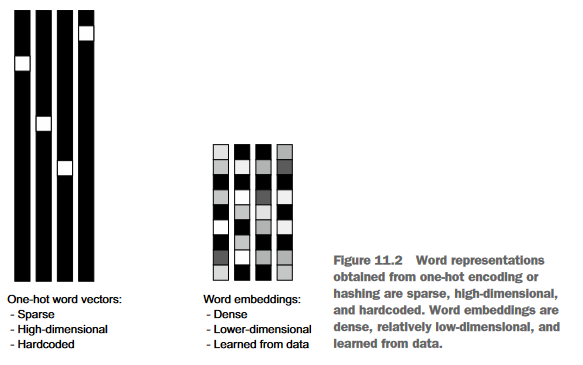\
Besides being dense representation, word embeddings are also structured representations, and their structure is learned from data. Similar words get embedded in close locations, and further, specific directions in the embedding space are meaningful.

There are two ways to obtain word embeddings:

* Learn word embeddings hointly with the main task. In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a NN.
* Load into your model word embeddings that were precomputed using a different machine learning task than the one you are trying to solve. These are called pretrained word embeddings.

#### Learning word embeddings with the embedding layer

Is there some ideal word-embedding space that would perfectly map human language and could be used for any natural language processing taks? Possibly, but we have yet to compute anything of the sort.
Also, there is no such a thing as human language, there are many different languages, and they are not isomorphic to one another, because a language is the reflection of a specific culture and a specific context. But more pragmatically, what makes a good word-embedding space depends heavily on your task: The perfect word-embedding space for an english language movie-review sentiment-analysis model look different from the perfect embedding space for an english language legal-document classification model, because the importance of certain semantic relationships varies from task to task.
It is thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It is about learning the weights of a layer: The Embedding layer.

In [32]:
# Instantiating an Embeddig layer

embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

The embedding layer is best understood as a dictionary that maps integer indices to dense vectors. It takes integers as input, looks up these integers in an internal dictionary, and returns the associated vectors. It is effectively a dictionary lookup.\
Word index -> Embedding layer -> Corresponding word vector\
The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size,sequence_length), where each entry is a sequence of integers. the layer then returns a 3D floating-point tensor of shape (batch_size, sequence_lenght, embedding_dimensionality).
when instantiating Embedding layer, its weights are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure- a kind of structure specialized for the specific problem for which you are trianing your model.


In [36]:
# Model that uses an Embedding layer trained from scratch

input = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks=[
    keras.callbacks.ModelCheckpoint("embedding_bidir_gru.keras", save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embedding_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

Trains much faster than the one-hot model. However, we are still some way off from the results of our basic bigram model. Part of the reason why is simply that the model is looking at slightly less data:
The bigram model processed full reviews, while our sequence model truncates sequences after 600 words.

#### Understanding Padding and Masking
One thing that's slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the output_sequence_length=max_length option in TextVectorization: sentences longer than 600 tokens are truncated to 600 tokens, and sentences shorter than 600 are padded with zeros at the end so that they can be concatenated together with other sequences to form continuous batches.
We use bidirectional RNN: two RNN layers running in parallel, with one processing the tokens in their natural order, and the other processing the same tokens in reverse. The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding, possibly for several hundreds of iterations if the original sentence was short. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaning less inputs.
We need some way to tell the RNN that it should skip these iterations. There is an API for it: masking.
The Embedding layer is capable of generating a mask that corresponds to its input data. This mask is a tensor of ones and zeros, of shape (batch_size, sequence_length), where the entry mask[i,t] indicates where timestep t of sample i should be skipped or not.
By default, this option is not active, you can turn it on by passing mask_zero=True to your Embedding layer. You can retrieve the mask with the compute_mask() method:\
> embedding_layer = Embedding(input_dim=10, output_dim=256, mask_zero=True)\
> some_input = [\
>... [4, 3, 2, 1, 0, 0, 0],\
>... [5, 4, 3, 2, 1, 0, 0],\
>... [2, 1, 0, 0, 0, 0, 0]]\
> mask = embedding_layer.compute_mask(some_input)\
<tf.Tensor: shape=(3, 7), dtype=bool, numpy=\
array([[ True, True, True, True, False, False, False],\
[ True, True, True, True, True, False, False],\
[ True, True, False, False, False, False, False]])>

In practice, you will almost never have to manage masks by hand. Instead Keras will automatically pass on the mask to every layer that is able to process it. This maskwill be used by RNN layers to skip masked steps. If your model returns an entire sequence, the mask will also be used by the loss function to skip masked steps in the output sequence.



In [37]:
# Using an Embedding layer with masking enabled

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()
callbacks=[
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

#### Using Pretrained Word Embeddings

Sometimes you have little training data available that you cannot use your data alone to learn an appropriate task-specific embedding of your vocabulary. In such cases, instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties one that captures generic aspects of language structure. The rationale behind using pretrained word embeddings in natural language processing is much the same as for using pretrained convnets in image classification: you don't have enough data available to learn truly powerful features on your own but expect that features you need are fairly generic like common visual features or semantic features.\
Such word embeddings are generally computed using word-occurrence statistics, using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio, but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the Word2Vec algorithm, which capture specific semantic properties, such as gender.\
There are various precomputed databases of word embeddings that you can download and use in Keras. Like Word2Vec or Glove, which is based on factorizing a matrix of word co-occurrence statistics.\



In [38]:
#Download Glove word-embeddings file
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2023-07-15 02:19:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu... 171.64.67.140
Connecting to nlp.stanford.edu|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-15 02:19:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu|171.64.67.140|:443... connected.
ERROR: cannot verify nlp.stanford.edu's certificate, issued by `/C=US/ST=MI/L=Ann Arbor/O=Internet2/OU=InCommon/CN=InCommon RSA Server CA':
  Self-signed certificate encountered.
To connect to nlp.stanford.edu insecurely, use `--no-check-certificate'.
Unable to establish SSL connection.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [40]:
# Parsing the Glove word-embeddings file
import numpy as np
path_to_glove_file="glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word]=coefs

print(f"fount {len(embeddings_index)} word vectors.")

fount 400000 word vectors.


Let's Build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim, dimensional vector for word of index i in the reference word index.

In [43]:
#Prepare GloVe word-embeddings matrix
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length = max_length,
)

embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens,embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Finally, we use a Constant initializer to load the pretrained embeddings in an Embedding layer. So as not to distrupt the pretrained representations during training, we freeze the layer via trainable=False\
>embedding_layer = layers.Embedding(\
    max_tokens,\
    embedding_dim,\
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),\
    trainable=False,\
    mask_zero=True,\
)

We now train a new model leveraging the 100-dimensional pretrained GloVe embeddings instead of 128-dimensional learned embeddings

In [45]:
#Model using pretrained Embedding layer
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras", save_best_only=True)
]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

We can see that in this task, embeddings aren't very helpful, because the dataset contains enough samples that it is possible to learn a specialized enough embedding space from scratch. However, leveraging pretrained embeddings can be very helpful when working with smaller datasets.

## The Transformer Architecture

Transformers were introduced in the paper "Attention is all you need". The gist of the paper is right in the title: as it turned out, a simple mechanism called "neural attention" could be used to build powerful sequence models that did not feature any recurrent layers or convolutions-
This unleashed a revolution in natural language processing. Neural attention has become one of the most influential ideas in Deep Learning.

### Understanding self-attention

As reading through a book, you may skim through some parts and attentively read others, depending on your goals or interests. What if your models did the same? It's a simple and powerful idea: not all input information seen by a model is equally important o the task at hand, so models should "pay more attention" to some features and "pay less attention" to other features.
This concept is similar to:

* Max pooling in convnets, looks at a pool of features in a spatial region and selects just one feature to keep. That's an "all or nothing" form of attention: keep the most important feature and discard the rest.
* TF-IDF normalization assigns importance scores to tokens based on how much information different tokens are likely to carry. Important tokens get boosted whiel irrelevant tokens get faded out. Continuous form of attention.

There are many forms of attention but they all start by computing importance scores for a set of features, with higher scores for more relevant features and lower scores for less relevant ones. How should we compute these scores, and what we should do with them, will vary from approach to approach.


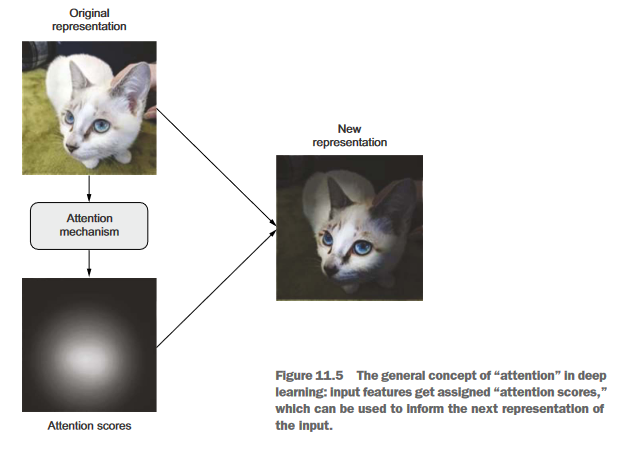

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can b used to make features context-aware.
We just used word embeddings, which are vector spaces capturing the "shape" of the semantic relationships between different words. In an embedding space, a single word has a fixed position, a fixed set of relationships with every other word in the space. But that is not quite how language works: The meaning of a word is usually context-specific.\
Clearly, a smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That's where self-attention comes in. The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context aware token representations. Consider an example sentence: "The train left the station on time". Now, consider one word in the sentence: station. What kind of station are we talking about? We can figure it out via self-attention.\
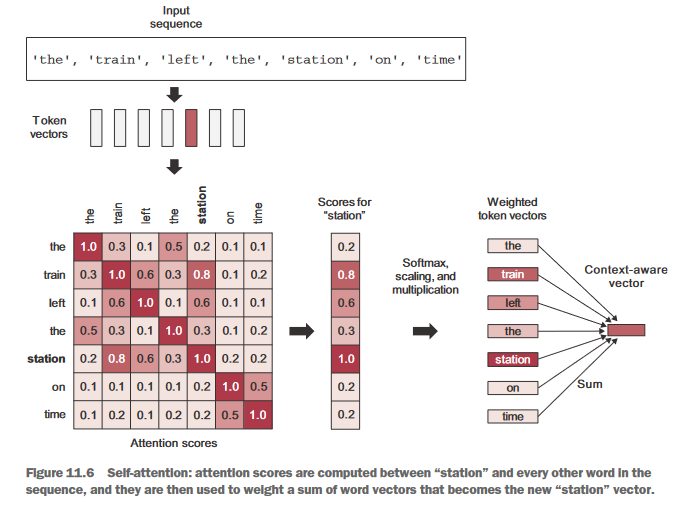

1. Compute relevancy scores between the vector for "station" and every other word in the sentence. These are our "attention scores". We are simply going to use the dot product between two vectors as a measure of strenght of their relationship. It's a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other, long before Transformers. In practive, these scores will also go through a scaling function and a softmax.
2. Compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to "station" will contribute more to the sum, while irrelevant words will contribute almost nothing. The resulting vector is our new representation for "station": a representation that incorporates the surrounding context. In particular, it includes part of the "train" vector, clarifying that it is, in fact, a "train station".
You'd repeat this process for every word in the sentence, producting a new sequence of vectors encoding the sentence.

> def self_attention(input_sequence):\
&emsp;output = np.zeros(shape=input_sequence.shape)\
&emsp;for i, pivot_vector in enumerate(input_sequence):\
&emsp;&emsp;scores = np.zeros(shape=(len(input_sequence),))\
&emsp;&emsp;for j, vector in enumerate(input_sequence):\
&emsp;&emsp;&emsp;scores[j] = np.dot(pivot_vector, vector.T)\
&emsp;&emsp;scores /= np.sqrt(input_sequence.shape[1])\
&emsp;&emsp;scores = softmax(scores)\
&emsp;&emsp;new_pivot_representation = np.zeros(shape=pivot_vector.shape)\
&emsp;&emsp;for j, vector in enumerate(input_sequence):\
&emsp;&emsp;&emsp;new_pivot_representation += vector * scores[j]\
&emsp;&emsp;output[i] = new_pivot_representation\
&emsp;return output

Of course in practice you would use a vectorized implementation. Keras has a built-in layer to handle it: the MultiHeadAttention layer.

>num_heads=4\
embed_dim = 256\
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)\
outputs=mha_layer(inputs,inputs,inputs)\

#### Generalized self-attention: The query-key-value model
So far, we have only considered one input sequence. However, the Transformer architecture was originally developed for machine translation, where you have to deal with two input sequences: the source sequence you are currenly translating and the target sequence you are converting it to. A transformer is a sequence-to-sequence model: it was designed to convert one sequence into another.\
Now, let's take a step back. The self-attention mechanism as we've introduced it performs the following, schematically:\
outputs = sum(inputs*pairwise_scores(inputs,inputs))\
This means "for each token in inputs, compute how much the token is related to every token in inputs, and use these scores to weight a sum of tokens from inputs." Crucially, there is nothing that requires the inputs to refer to the same input sequence. In the general case, you could be doing this with three different sequences. We'll call them "query", "keys" and "values". The operation becomes "for each element in the query, compute how much the element is related to every key, and use these scores to weight a sum of values":\
outputs = sum(values * pairwise_scores(query, keys))\
This terminology comes from search engines and recommender systems. Imagine you are typing up a query to retrieve a photo from your collecion. Internally, each of your pictures in the database is described by a set of keywords. We'll call those "keys". the search engine will start by comparing your query to the keys in the database. It will then rank those keys by strenght of match, relevance, and it will return the pictures associated with the top N matches, in order of relevance.\
Conceptually, this is what Transformer-style attention is doing. You've got a reference sequence that describes something you are looking for: the query. You have got a body of knowledge that you are trying to extract information from: the values. Each value is assigned a key that describes the value in a format that can be readily compared to a query. You simply match the query to the keys. Then you return a weighted sum of values.\
In practice, the keys and the values are often the same sequence. In machine tranlation the query would be the target sequence, and the source sequence would play the roles of both keys and values: for each element of the target, you want to go back to the source and identify the different bits that are related to it. And naturally, if you are just doing sequence classification, then query, keys, and values are all the same: you are comparing a sequence to itself, to enrich each token with context from the whole sequence.\
That explains why we needed to pass inputs three times to our MultiHeadAttention layer.\
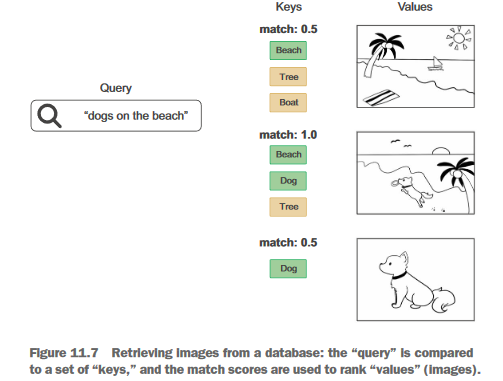

### Multi-head attention
Multi-head attention is an extra tweak to the self-attention mechanism, introduced in attention is all you need. The multi-head moniker refers to the fact that thte output space of the self-attention layer gets factored into a set of independent three independent sets of dense projections, resulting in three separate vectors. Each vector is processed via neural attention, adn the three outputs are concatenated back together into a single output sequence. Each such subspace is called a head.\
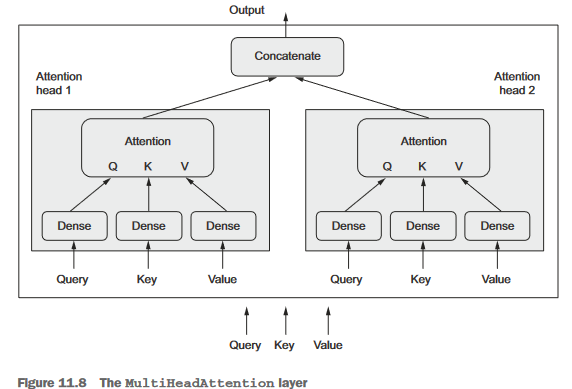
The presence of the learnable dense prohections enables the layer to actually learn something, as opposed to being a purely stateless transformation that would require helps the layer ean different groups of  features for each token, where features within one group are correlated with each other but are mostly independent from features in a different group.\
This is similar to what makes depthwise separable convolutions work: in a depthwise separable convolution, the output space of the convolution is factored into many subspaces that get learned independetly. Both in the case of depthwise separable convolutions, and in the case of a closely related approach, grouped convolutions. Multi-head attention is simply the application of the same idea to self-attention.

### The Transformer encoder
If adding extra dense projection is so useful, why don't we also apply one or two two the output of the attention mechanism?\
Our model is starting to do a lot, so we might want to add residual connections to make sure we don't destroy any valuable information along the way, also normalization layers are supposed to help gradients flow better during backpropagation.\
That's roughly the thought process that could be unfolded in the minds of the inventors of the Transformer architeture at the time. Factoring outputs into multiple independent spaces, adding residual connections, adding normalization layers, all these are standard architecture patterns that one would be wise to leverage in any complex model. Together, these bells and whistles from the Transformer encoder.\
The original Transformer architecture consists of two parts: a Transformer encoder that processes the source sequence, and a Transformer decoder that uses the source sequence to generate a translated version.\
Crucially, the encoder part can be used for text classification, it's a very generic module that ingests a sequence and learns to turn it into a more useful representation.\
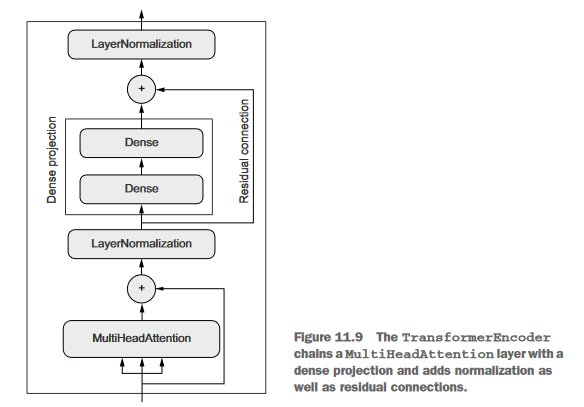

In [46]:
#Transformer encoder implemented as a subclassed Layer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask
        )
        proj_input = self.layernorm_1(inputs+attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input+proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    

##### Saving custom layers

When writing custom layers, make sure to implement the get_config method: this enables the layer to be reinstantiated from its config dict, which is useful during model saving and loading. The method should return a Python dict that contains the values of the constructor arguments used to create the layer.\
All Keras layers can be serialized and deserialized as follows:\

>config = layer.get_config()\
new_layer = layer.__class__.from_config(config)\

For instance:\

>layer=PositionalEmbedding(sequence_length, input_dim, output_dim)\
config = layer.get_config()\
new_layer = PositionalEmbedding.from_config(config)\

When saving a model that contains custom layers, the savefile will contain these config dicts. When loading the model from the file, you should provide the custom layer classes to the loading process, so that it can make sense of the config objects:\

>model = keras.models.load_model(filename, custom_objects={"PositionalEmbedding": PositionalEmbedding})

You can see that the normalization layers we are using are not the BatchNormalization layers like those we have used before in image models. That is because BatchNormalization does not work well for sequence data. Instead, we are using the LayerNormalization layer, which normalizes each sequence independently form other sequences in the batch.\
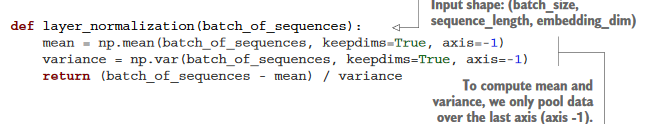

Compare to BatchNormalization:\
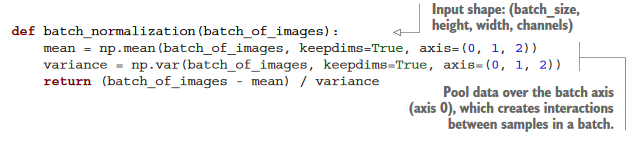

While BatchNormalization collects information from many samples to obtain accurate statistics for the feature means and variances, LayerNormalization pools data within each sequence separately, which is more appropriate for sequence data.\
Now after having implemented the Encoder, we can use it to assemble a text-classification model similar to the GRU-based one.



In [48]:
## Using Transformer encoder for text classification

vocab_size = 20000
embed_dim=256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None, ), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 256)         5120000   
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257 

In [49]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True)
]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder":TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
2188/2188 [==============================] - 164s 74ms/step - loss: -2888.8684 - accuracy: 0.1428 - val_loss: 6654.1738 - val_accuracy: 0.5000
Epoch 2/20
2188/2188 [==============================] - 192s 88ms/step - loss: -15990.5771 - accuracy: 0.1429 - val_loss: 22835.8555 - val_accuracy: 0.5000
Epoch 3/20
2188/2188 [==============================] - 219s 100ms/step - loss: -40153.4648 - accuracy: 0.1429 - val_loss: 48581.3008 - val_accuracy: 0.5000
Epoch 4/20
2188/2188 [==============================] - 229s 105ms/step - loss: -75711.0859 - accuracy: 0.1429 - val_loss: 84533.1250 - val_accuracy: 0.5000
Epoch 5/20
2188/2188 [==============================] - 236s 108ms/step - loss: -123540.8906 - accuracy: 0.1429 - val_loss: 130747.0312 - val_accuracy: 0.5000
Epoch 6/20
2188/2188 [==============================] - 241s 110ms/step - loss: -183308.8125 - accuracy: 0.1429 - val_loss: 187559.6094 - val_accuracy: 0.5000
Epoch 7/20
2188/2188 [==============================] - 24

There is something off, the transformer encoder in action wasn't a sequence model at all. It is composed of dense layers that process sequence tokens independently from each other, and an attention layer that looks at the tokens as a set. You could change the order of the tokens in a sequence, and you'd get the exact same pairwise attention scores and the exact same context-aware representations. If you were to completely scrample the words in every movei review, the model would not notice, and you would still get the exact same accuracy. Self-attention is a set-processing mechanism, focused on the relationships between pairs of sequence elements, blind to whether these elements occur at the beginning, at the end or in the middle of a sequence. So why do we say that Transformer is a seqience model? How could it possibly be good for machine translation if it doesn't look at word order?\
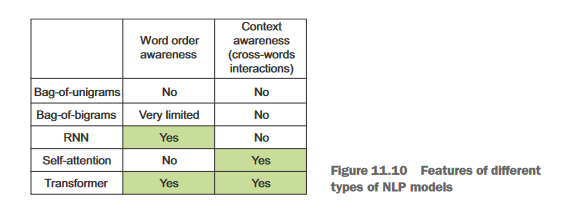\
We mentioned that Transformer was a hybrid approach that is technically order-agnostic, but that manually injects order information in the representations it processes. This is the missing ingredient! It's called positional encoding.

#### Using positional encoding to re-inject order information

The idea behind positional encoding is very simple: to gice the model access to word-orderinformation, we are going to add the word's position in the sentence to each word embedding. Our input word embedding will have two components: the ususal word vector, which repesents the word independently of any specific context, and a position vector, which represents the position of the word in the current sentence. Hopefully, the model will then figure out how to best leverage this additional info.\
The simplest scheme would be to concatente the word's position to its embedding vector. You would add a "position" axis to the vector and fill it with 0 for the first word in the sequence, 1 for the second, and so on.\
This may not be ideal, however, because the positions can potentially be very large integers, which will distrupt the range of values in the embedding vector.\
The original paper used an interesting trick to encode word positions: it added to theword embeddings a vector containing values in the range [-1,1] that varied cyclically depending on the position. This trick offers a way to uniquely characterize any integer in a large range via a vector of small values. It's clever, but it is not what we are going to use in our case. We'll do something simpler and more effective: we will learn position-embedding vectors the same way we learn to embed word indices. We will then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embeddings. This technique is called "positional embedding".

In [51]:
# Implement Positional Embedding as a subclassed layer

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim = input_dim, output_dim = output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim = sequence_length, output_dim = output_dim
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self,inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim
        })
        return config

In [52]:
#Putting all together: A text-classification transformer

vocab_size = 20000
sequence_lenght = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_lenght, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras", save_best_only=True)
]

model.fit(int_train_ds, validation_data = int_val_ds, epochs=20, callbacks=callbacks)

model = keras.models.load_model("full_transformer_encoder.keras", custom_objects={"TransformerEncoder":TransformerEncoder, "PositionalEmbedding": PositionalEmbedding})

print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_2 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 1)                 257       
                                                          

### When to use sequence models over bag-of-words models

You may hear that bag.of.words methods are outdated, and that Transformer based sequence models are the way to go, no matter the task or dataset. This is not the case: a small stack of Dense layers on top of a bag-of-bigrams remains a perfectly valid and relevant approach in many cases. In fact, among the various techniques that we have tried, the best performing so far has been the bag-of-bigrams.\
So, when should we prefer one approach over the other?\
It turns out that when approaching a new text-classification task, you should pay close attentin to the ratio between the number of samples in your training data and the mean number of words per sample. If that ratio is small then the bag-of-bigrams model will perform better. If that ratio is higher than 1500, then you should go with a sequence model. In other words, sequence models work best when lots of training data is available and when each sample is relatively short.\
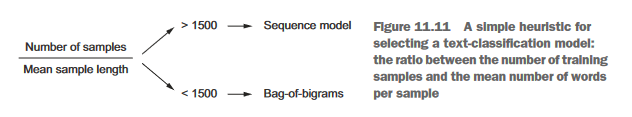
So if you are classifying 1000-words long documents, and you have 100000 of them, you should fgo with a bigram model. If you are classifying tweets that are 40 words long on average, and you have 50000 of them, you should use also a bigram model. But if you in crease your dataset size to 500000 tweets, go with a Transformer encoder.\
This intuitively makes sense: the input of a sequence model represents a richer and more complex space, and thus it takes more data to map out that space, meanwhile, a plain set of terms is a space so simple that you can train a logistic regression on top using just a few hundreds or thousands of samples. In addition, the shorter a sample is, the less the model can afford to discard any of he information it contains. In particular, word order becomes more important, and discarding it can create ambiguity.\
Keep in mind that this heuristic rule was developed specifically for text classification. It may not necessarily hold for other NLP tasks, when it omes to machine translation Transformer shines especially for long sequences, compared to RNN.

### Beyond text classification: Sequence-to-sequence learning

You now possess all of the tools you will need to tackle most NLP tasks. However, you have only seen these tools in action on a single problem: text classification. This is an extremely popular use case, but there is a lot more to NLP than classification. In this section you will deepen your expertise by learning about sequence-to-sequence moedls.\
A sequence-to-sequence model takes a sequence as input and translates it into a different sequence. This is the task at the heart of many of most successful applications of NLP:
* Machine Translation-Convert a paragraph in a source language to its equivalent in a target language.
* Text summarization - Convert a long document to a shorter version that retains the most important information
* Question answering - Convert an input questio into its answer
* Chatbots - Convert a dialogue prompt into a reply to this prompt, or convert the history of a conversation into the next reply in the conversation.
* Text generation - Convert a text prompt into a paragraph that completes the prompt.

The general template behind seq2seq models is \
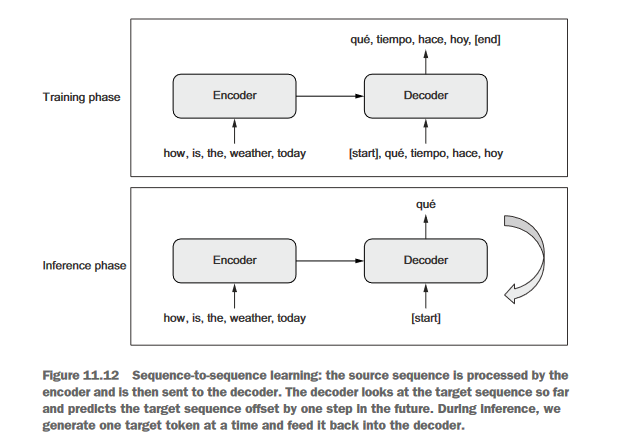\
During training:
* An encoder model turns the source sequence into an intermediate representation.
* A decoder is trained to predict the next token i in the target sequence by looking at both previous tokens (0 to i-1) and the encoded source sequence.

During inference, we don't have access to the target sequence, we are trying to predict it from scratch. We will have to generate it one token at a time:
1. We obtain the encoded source sequence from the encoder.
2. The decoder starts by looking at the encoded source sequence as well as an initial "seed" token, and uses them to predict the first real token in the sequence.
3. The predicted sequence so far is fed back into the decoder, which generates the next token, and so on, until it generates a stop token.

#### A machine Translation example

We demonstrate seq2seq modelling on a machine translation task. Machine translation is precisely what Transformer was developed for. We will start with a recurrent sequence model, and we will follow up with the full Transformer architecture.\
We are using an English-Spanish translation dataset.

In [53]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2023-07-16 16:17:38--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com... 142.251.209.48, 216.58.204.144, 142.250.184.80, ...
Connecting to storage.googleapis.com|142.251.209.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: `spa-eng.zip'

     0K .......... .......... .......... .......... ..........  1%  414K 6s
    50K .......... .......... .......... .......... ..........  3%  396K 6s
   100K .......... .......... .......... .......... ..........  5% 1015K 5s
   150K .......... .......... .......... .......... ..........  7%  878K 4s
   200K .......... .......... .......... .......... ..........  9% 1.25M 4s
   250K .......... .......... .......... .......... .......... 11% 1.46M 3s
   300K .......... .......... .......... .......... .......... 13% 1.27M 3s
 

In [54]:
#Parse the file

text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []

for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start]" + spanish +  " [end]"
    text_pairs.append((english,spanish))


In [55]:
import random
print(random.choice(text_pairs))

('Tom has money enough to buy the house he wants.', '[start]Tom tiene el dinero suficiente para comprar la casa que quiere. [end]')


In [56]:
#Let's shuffle and split
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) -2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples+num_val_samples]
test_pairs = text_pairs[num_train_samples+num_val_samples:]

Next, let's prepare two separate TextVectorization lauers: one for english and one for spanish. We are going to need to customize the way strings are preprocessed:
* We need to preserve the "[start]" and "[end]" tokens that we've inserted. By default, the characters [and] would be stripped, but we want to keep them around so we can tell apart the word "strart" and the token "[start]"
* Punctuation is different from language to language! In the spanish TextVectorization layer, if we are going to strip punctuation characters, we need to also strip the character ¿.

Note that for non-toy translation model, we would treat punctuation characters as separate tokens rather than stripping them, since we would want to be able to generate correctly punctuated sentences.

In [67]:
#Vectorizing English and Spanish text pairs
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]","")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_lenght = 20

#English
source_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode = "int",
    output_sequence_length=sequence_lenght,
)

#Spanish
target_vectorization = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode="int",
    output_sequence_length=sequence_lenght,
    standardize=custom_standardization
)

train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

Finally, we can turn our data into a tf.data pipeline. We want it to return a tuple (input, target) where input is a dict with two keys, "encoder_inputs" and "decoder_inputs", and target is the spanish sentence offset by one step ahead.

In [68]:
#Prepare dataset for translation

batch_size = 64

def format_dataset(eng,spa):
    eng=source_vectorization(eng)
    spa=source_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:,:-1]
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_text, spa_text = zip(*pairs)
    eng_texts = list(eng_text)
    spa_texts = list(spa_text)

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [69]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 19)
targets.shape: (64, 19)


### Sequence-to-sequence learning with RNNs

Recurrent neural networks dominated sequence-to-sequence learning from 2015-2017 before being overtaken by Transformer. They were the basis for many real-world machine-translation systems. It is still worth leraning about this approach today, as it provides and easy entry point to understanding seq2seq models.\
The simplest, naive way to use RNNs to turn a sequence into another sequence is to keep the output of the RNN at each time step. In keras it would be like:\
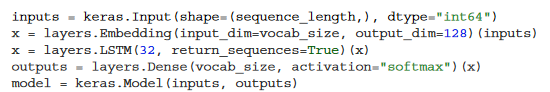\
However, there are two major issues with this approach:
* The target sequence must always be the same length as the source sequence. In practice, this is rarely the case. Technically, this is not critical as you could always pad either the source sequence or the target sequence to make their lengths match.
* Due to the sept-by-step nature of RNNs, the model will only be looking at tokens 0...N in the source sequence in order to predict token N in hte target sequence. This contraint makes this setup unsuitale for most tasks, and particularly translation.

If you are a human translator, you would start by reading the entire source sentence before starting to translate. this is especially important if you are dealing with languages that hve wildly different word ordering, like english and japanese. This is exactly what standard seq2seq do.\
In a proper seq2seq setup, you would first use  an RNN(encoder) to turn the entire source sequence into a single vector (or a set of vectors). This could be the last output of the RNN, or its final internal starte vectors.Then you'd use this vector as the initial state of another RNN(the decoder), which would look at elements 0..N in the target sequence, and try to predict step N+1.\
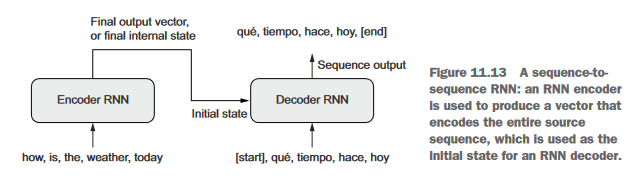

In [70]:
#GRU-based encoder

from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)

Now, let's add the decoder, a simple GRU layer that takes as its initial state the encoded source sentence. On top of it, we add a Dense layer that produces for each output step a probability distribution over the Spanish vocabulary.

In [71]:
#Gru-based decoder and end-to-end model

past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

During training, the decoder takes as input the entire target sequence, but thanks to the step-by-step nature of RNNs, it only looks at tokens 0..N in the input to predict token N in the output. This means we only use information from the past to predict the future, as we should, otherwise we'd be cheating, and our model would not work at inference time.

In [72]:
#Training our recurrent seq2seq model

seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 157s 112ms/step - loss: 0.3257 - accuracy: 0.7728 - val_loss: 0.2447 - val_accuracy: 0.8142
Epoch 2/15
1302/1302 [==============================] - 165s 127ms/step - loss: 0.2408 - accuracy: 0.8164 - val_loss: 0.2177 - val_accuracy: 0.8284
Epoch 3/15
1302/1302 [==============================] - 170s 131ms/step - loss: 0.2132 - accuracy: 0.8348 - val_loss: 0.2106 - val_accuracy: 0.8321
Epoch 4/15
1302/1302 [==============================] - 170s 130ms/step - loss: 0.1922 - accuracy: 0.8492 - val_loss: 0.2072 - val_accuracy: 0.8372
Epoch 5/15
1302/1302 [==============================] - 160s 123ms/step - loss: 0.1729 - accuracy: 0.8634 - val_loss: 0.2109 - val_accuracy: 0.8375
Epoch 6/15
1302/1302 [==============================] - 163s 125ms/step - loss: 0.1551 - accuracy: 0.8766 - val_loss: 0.2249 - val_accuracy: 0.8308
Epoch 7/15
1302/1302 [==============================] - 162s 124ms/step - loss: 0.1378 - accuracy: 0.8895 - val_

We have picked accuracy as a crude way to monitor validation-set performance during training.In practice, next-token accuracy is not a great metric for machine translation models, in particular becuase it makes the assumption that the correct target tokens from 0 to N are already known when predicting token N+1. In reality, during inference, you are generating the target sentence from scratch, and you cannot rely on previously generated tokens being 100% correct.\
If you work on a real-work machine translation system, you will liely use "BLEU scores" to evaluate your models, a metric that looks at entire generated sequences and that seems to correlate well with human perception of translation quality.\
A last, let's use our model for inference. We pick a few sentences in the test set and check how our model translates them. We will start from the seed token, "[start]", and feed it into the decoder model, together with the encoded English source sentence. We will retrieve a next-token prediction, and we will re-inject it into the decoder repeatedly, sampling one new target toke at each iteration, until we get to "[end]" or reach the maximum sentence length

In [73]:
#Translate new sentences with RNN encoder decoder
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence]
        )
        sampled_token_index = np.argmax(next_token_predictions[0,i,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))
    

-
We've got plenty of time.


1/1 [==============================] - 0s 92ms/step
[start] [UNK] [UNK] [UNK] verte  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
Her father is an excellent pianist.
1/1 [==============================] - 0s 69ms/step
[start] [UNK] [UNK] [UNK] [UNK] [UNK] verte  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
The children are growing tired.
1/1 [==============================] - 0s 96ms/step
[start] [UNK] [UNK] [UNK] verte  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
Tom prepared lunch for Mary.
1/1 [==============================] - 0s 63ms/step
[start] [UNK] [UNK] [UNK] los verte  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
-
Tom asked me if I knew Mary.
1/1 [==============================] - 0s 73ms/step
[start] lo [UNK] [UNK] [UNK] [UNK] [start]tom [UNK] verte  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UN

Note that this inference setup is rather inefficient, since we reprocess the entire source sentence and the entire generated target sentence every time we sample a new word. In a practical application, you would factor the encoder and the decoder as two separate models, and your decoder would only run a single step at each token-sampling iteration, reusing its previous internal state.

There are many ways this model could be improved: We could use a deep stack of recurrent layers for both the encoder and the decoder. We could use an LSTM instead of a GRU. And so on. Beyond such tweaks, the RNN approach to seq2seq learning has a few fundamental limitations:
* The source sequence representation has to be held entirely in the encoder state vector(s), which puts significant limitations on the size and complexity of the sentences you can translate. It's a bit as if a human were translating a sentence entirely from memory, without looking twice at the source sentence while producing the translation.
* RNNs have trouble dealing with very long sequences, since they tend to progressively forget about the past, by the time you have reached the 100th token in either sequence, little information remains about the start of the sequence. That means RNN-based models can't hold onto long-term context, which can be essential for translating long documents.


### Sequence-to-Sequence learning with Transformer

Sequence-to-sequence learning is the task where Transfoerm really shines. Neural attention enables Transfromer models to successfully process sequences that are considerably longer and more complex than those RNNs can handle.\
In a sequence-to-sequence Transformer, the Transformer encoder would naturally play the role of the encoder, which reads the source sequence and produces an encoded representation of it. Unlike our previous RNN encoder, though, the Transformer encoder keeps the encoded represetnation in a sequence format: it's a sequence of context-aware embedding vectors.\
The second half of the model is the Transformer decoder. Just like the RNN decoder, it reads tokens 0..N in the target sequence and tries to predict token N+1. Crucially, while doing this, it uses neural attention to identify which toekns in the encoded source sentence are most closely related to the target token it's currently trying to predict.\
Recall the query-key-value model: in a Transformer decoder, the target sequence serves as an attention "query" that is used to pay closer attention to different parts of the source sequence.

#### The Transformer Decoder
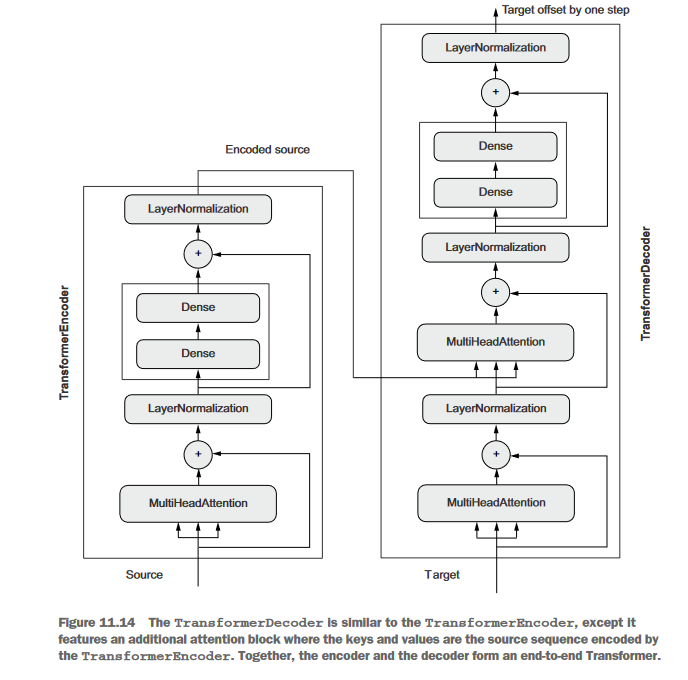\
Look at the decoder internals: you will recognize that it looks very similar to the Transformer encoder, except that an extra attention block is inserted between the self-attention block applied to the target seuqence and the dense layers of the exit block.\
Let's implement it. Like the TransformerEncoder, we will use a Layer subclass.

In [98]:
#Transformer Decoder

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

The call() method is almost a straightforward rendering of the connectivity diagram. But there is an additional detail we need to take into account: causal padding. Causal padding is absolutelu critical to successfully training a seq2seq Transformers. Unlike an RNN, which looks at its input one step at a time, and thus will only have access to steps 0..N to generate output step N, the TransformerDecoder is order-agnostic: it looks at the entire target sequence at once. If it were allowed to use its entire model would thus achieve perfect training accuracy, but of course, when running inference, it would be completely useless, since input steps beyond N are not available.\
The fix is simple: We will mask the upper half of the pairwise attention matrix to prevent the model from paying any attention to inforamation from the future, only info from tokens 0..N in the target sequence should be considered when generating target token N+1. To do this, we will add a get_causal_attention_mask(self, inputs) method to our TransformerDecoder to retrieve an attention mask that we can pass to our MultiHeadAttention layers.

#### Putting all together: A transformer for machine translation

The end-to-end Transformer is the model we will be training. It maps the source sequence and the target sequence to the target sequence on step in the future. It straightforwardly combines the pieces we have built so far: PositionalEmbedding layers, the TransformerEncoder, and the TransformerDecoder. Note that both Encoder and Decoder are shape-invariant, so you could be stacking many of them to create a more powerful encoder or decoder.

In [99]:
#Positional Embedding Layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [100]:
#End-to-end Transformer
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_lenght, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_lenght, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [101]:
#Train Seq2Seq Transformer
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30


ValueError: in user code:

    File "d:\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "d:\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "d:\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "d:\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\rullo\AppData\Local\Temp\__autograph_generated_filem4hijvxq.py", line 31, in tf__call
        attention_output_2 = ag__.converted_call(ag__.ld(self).attention_2, (), dict(query=ag__.ld(attention_output_1), value=ag__.ld(encoder_outputs), key=ag__.ld(encoder_outputs), attention_mask=ag__.ld(padding_mask)), fscope)

    ValueError: Exception encountered when calling layer "transformer_decoder_7" "                 f"(type TransformerDecoder).
    
    in user code:
    
        File "C:\Users\rullo\AppData\Local\Temp\ipykernel_12344\2521084584.py", line 57, in call  *
            attention_output_2 = self.attention_2(
        File "d:\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ValueError: Exception encountered when calling layer "softmax_1" "                 f"(type Softmax).
        
        Dimensions must be equal, but are 20 and 19 for '{{node model_20/transformer_decoder_7/multi_head_attention_28/softmax_1/add}} = AddV2[T=DT_FLOAT](model_20/transformer_decoder_7/multi_head_attention_28/einsum/Einsum, model_20/transformer_decoder_7/multi_head_attention_28/softmax_1/mul)' with input shapes: [?,8,19,20], [?,1,19,19].
        
        Call arguments received by layer "softmax_1" "                 f"(type Softmax):
          • inputs=tf.Tensor(shape=(None, 8, 19, 20), dtype=float32)
          • mask=tf.Tensor(shape=(None, 1, 19, 19), dtype=int32)
    
    
    Call arguments received by layer "transformer_decoder_7" "                 f"(type TransformerDecoder):
      • inputs=tf.Tensor(shape=(None, 19, 256), dtype=float32)
      • encoder_outputs=tf.Tensor(shape=(None, 20, 256), dtype=float32)
      • mask=tf.Tensor(shape=(None, 19), dtype=bool)


In [102]:
#Translate new sentences with our Transformer model

import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)),spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence="[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:,:-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence]
        )
        sampled_token_index = np.argmax(predictions[0,i,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
We collect stamps from all around the world.


InvalidArgumentError: Exception encountered when calling layer "softmax_1" "                 f"(type Softmax).

{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2]

Call arguments received by layer "softmax_1" "                 f"(type Softmax):
  • inputs=tf.Tensor(shape=(1, 8, 19, 20), dtype=float32)
  • mask=tf.Tensor(shape=(1, 1, 19, 19), dtype=int32)